In [181]:
import numpy as np
import matplotlib.pyplot as plt
import qutip

import json, os, sys
sys.path.append("../utils")

plt.style.use("../matplotlib_style/standard_plot_style.mplstyle")

## Load data

In [182]:
path = os.path.join(os.getcwd(), 'ss_data', "single_shot_1us_164010", "state_after.json")

durations = np.array([0.5, 1, 2, 5, 10])
names     = ["0p5us_164004", "1us_164010", "2us_164016", "5us_164020", "10us_164027"]

def get_IQ_states(folder_name):
    path = os.path.join(os.getcwd(), 'ss_data', f"single_shot_{folder_name}", "state_after.json")

    with open(path) as file:
        data = json.load(file)

    # Get the data
    IQ_state_0 = (
        1   * np.array(data["experiment_results"]["Readout signal (final_I) ss"]["value"])[:, 0] + 
        1j  * np.array(data["experiment_results"]["Readout signal (final_Q) ss"]["value"])[:, 0]
    )

    IQ_state_1 = (
        1   * np.array(data["experiment_results"]["Readout signal (final_I) ss"]["value"])[:, 1]+ 
        1j  * np.array(data["experiment_results"]["Readout signal (final_Q) ss"]["value"])[:, 1])
    
    return {"0": IQ_state_0, "1": IQ_state_1}


IQ_state_0 = []
IQ_state_1 = []
for name in names:
    IQ_states = get_IQ_states(name)
    IQ_state_0.append(IQ_states["0"])
    IQ_state_1.append(IQ_states["1"])
    
IQ_state_0 = np.array(IQ_state_0)
IQ_state_1 = np.array(IQ_state_1)

## Functions

In [183]:
from scipy.special import factorial

def Q_of_rho(rho, alphas):
    rho = rho.full()
    n_cutoff = rho.shape[0]

    alphas = alphas / np.sqrt(2)
    normalization = np.exp(- alphas * alphas.conj() / 2)

    # Basis change
    ns = np.expand_dims(np.arange(n_cutoff), 1)
    P  = normalization * np.power(alphas, ns) / np.sqrt(factorial(ns))

    Q_output = 1 / np.pi * np.einsum("ij, jk, ki -> i", P.T.conj(), rho, P)
    return Q_output.real

## Visual Inspection / calibration

In [184]:
from scipy.stats import multivariate_normal

which = 0


data = np.vstack([IQ_state_0[which].real, IQ_state_0[which].imag])
filter = abs(IQ_state_0[which]) < np.percentile(abs(IQ_state_0[which]), 95)


def multivariate_fit(x):
    means       = x[:2]
    variance   = x[2] ** 2 + 1e-15
    return - 2 * np.sum(np.log(multivariate_normal.pdf(data.T, mean = means, cov = variance))[filter])


from iminuit import Minuit
minimizer = Minuit(multivariate_fit, (0, 0, 1))

minimizer.limits = ((-1, 1), (-1, 1), (0, 1))


minimizer.migrad()

E VariableMetricBuilder Initial matrix not pos.def.


/tmp/ipykernel_27706/3952080463.py:13: RuntimeWarning: divide by zero encountered in log
  return - 2 * np.sum(np.log(multivariate_normal.pdf(data.T, mean = means, cov = variance))[filter])


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -1.413e+05                 │              Nfcn = 277              │
│ EDM = 1.9e-07 (Goal: 0.0002)     │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ x0   │ -160.1e-6 │  2.1e-6   │            │            │   -1    │    1    │       │
│ 1 │ x1   │  58.1e-6  │  2.1e-6   │            │            │   -1    │    1    │       │
│ 2 │ x2   │ 142.8e-6  │  1.0e-6   │            │            │    0    │    1    │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬────────────────────────────┐
│    │       x0       x1       x2 │
├────┼────────────────────────────┤
│ x0 │ 4.29e-12  7.6e-18 2.86e-15 │
│ x1 │  7.6e-18 4.29e-12 2.85e-15 │
│ x2 │ 2.86e-15 2.85e-15 1.07e-12 │
└────┴────────────────────────────┘

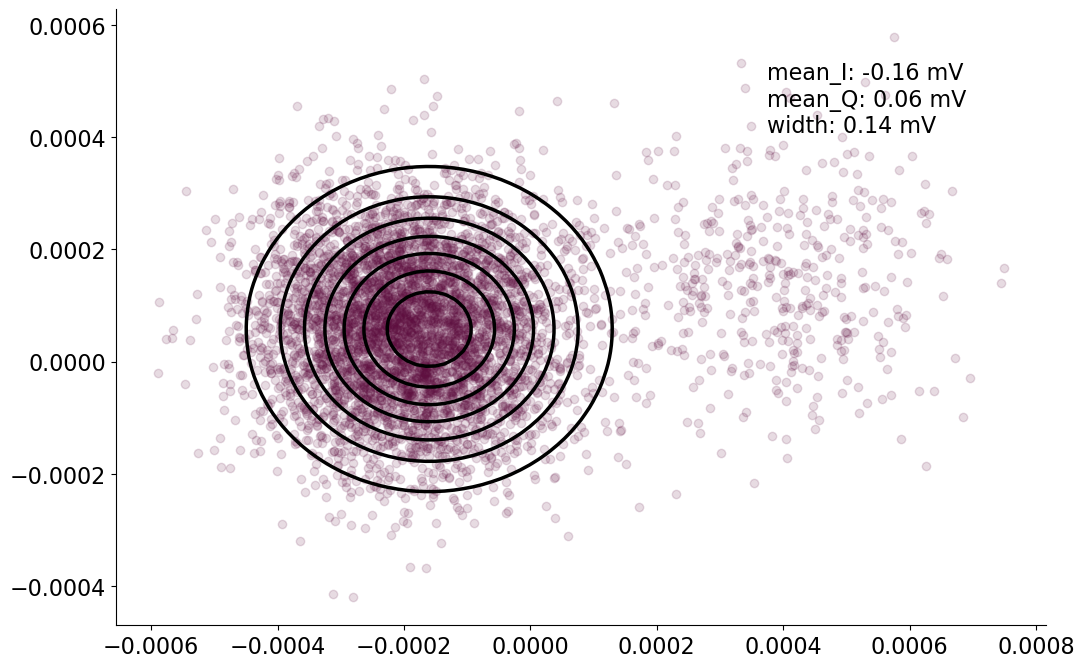

In [185]:
fig, ax = plt.subplots()

ax.scatter(IQ_state_0[which].real, IQ_state_0[which].imag, label = "0", alpha = 0.15)

xs = np.linspace(*ax.get_xlim(), 100)
ys = np.linspace(*ax.get_ylim(), 100)

from qutip import QFunc

qfunc = QFunc(xs, ys)

X, Y = np.meshgrid(xs, ys)

Z = multivariate_normal.pdf(np.vstack([X.flatten(), Y.flatten()]).T, mean = minimizer.values[:2], cov = minimizer.values[2] ** 2)

ax.contour(X, Y, Z.reshape(X.shape), colors = "k")

write = {
    "mean_I": minimizer.values["x0"] * 1000,
    "mean_Q": minimizer.values["x1"] * 1000,
    "width":  minimizer.values["x2"] * 1000
}

write_string = "\n".join([f"{key}: {value:.2f} mV" for key, value in write.items()])


ax.text(0.7, 0.8, write_string, transform = ax.transAxes);

In [186]:
def transformation(data):
    return (data - minimizer.values["x0"] - 1j * minimizer.values["x1"])  / minimizer.values["x2"] * 2


For now. Simply scale such that the mean is in (0, 0) and we set the standard deviation to be 1/2, to make sure the vacuum state fits:

In [187]:
data_0 = transformation(IQ_state_0[which])
data_1 = transformation(IQ_state_1[which])

data = np.vstack([data_1.real, data_1.imag])
filter = data_1.real > 7.0


def multivariate_fit(x):
    means       = x[:2]
    variance   = x[2] ** 2 + 1e-15
    return - 2 * np.sum(np.log(multivariate_normal.pdf(data.T, mean = means, cov = variance))[filter])


from iminuit import Minuit
minimizer = Minuit(multivariate_fit, (0, 0, 1))

minimizer.limits = ((0, 25), (0, 25), (0, 1))


minimizer.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2.598e+04                  │              Nfcn = 81               │
│ EDM = 1.13e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │       SOME Parameters at limit       │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ x0   │   8.810   │   0.018   │            │            │    0    │   25    │       │
│ 1 │ x1   │   1.146   │   0.018   │            │            │    0    │   25    │       │
│ 2 │ x2   │  1.00000  │  0.00006  │            │            │    0    │    1    │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬────────────────────────────┐
│    │       x0       x1       x2 │
├────┼────────────────────────────┤
│ x0 │ 0.000322 4.21e-17 1.97e-19 │
│ x1 │ 4.21e-17 0.000322 2.22e-19 │
│ x2 │ 1.97e-19 2.22e-19 1.04e-21 │
└────┴────────────────────────────┘

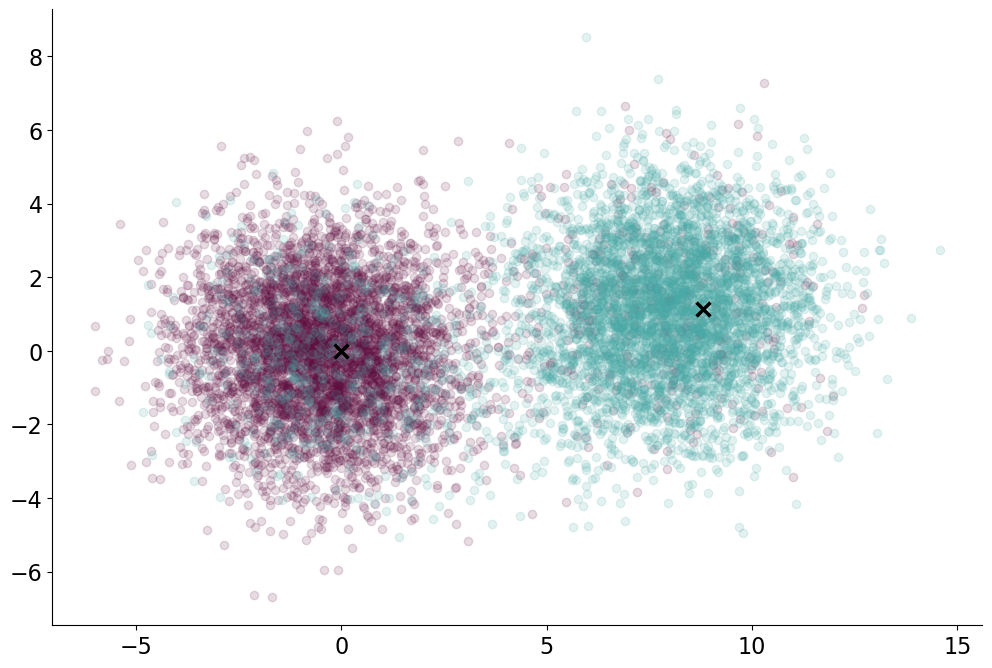

In [188]:
fig, ax =   plt.subplots()

ax.scatter(data_0.real, data_0.imag, cmap = "Blues", alpha = 0.15)
ax.scatter(data_1.real, data_1.imag, cmap = "Reds", alpha = 0.15)

ax.scatter(0, 0, marker = "x", color = "k", s = 100, zorder = 10)
ax.scatter(minimizer.values["x0"], minimizer.values["x1"], marker = "x", color = "k", s= 100, zorder = 10)

xs = np.linspace(*ax.get_xlim(), 100)
ys = np.linspace(*ax.get_ylim(), 100)

X, Y = np.meshgrid(xs, ys)

x1, y1 = minimizer.values["x0"], minimizer.values["x1"]

## Setup quantum experiment.
We define the following elements:
- Start with a density matrix of qubit $\otimes$ resonator
- Do an initial decoherence error
- Move the resonator toward the second blob if it is in state $|1\rangle$


In [189]:
from qutip import (destroy, sigmaz, basis, num, tensor, lindblad_dissipator, 
                   qeye, operator_to_vector, ket2dm, sprepost, vector_to_operator,
                   spre)

resonator_states    = 50
timesteps           = 1000
T1                  = 10
preperation_fidelty = 0.90 

# Operators
a       = destroy(resonator_states)
a_dag   = a.dag()

# Check
sigma_z = sigmaz()
is_1    = num(2)

# Decay
decay_operator = destroy(2)

total_distance  = x1 + 1j * y1
total_time      = durations[which]
gamma1          = 1 / T1   

print("total distance \t" +  f"{total_distance.real:.2f}" + " + " + f"{total_distance.imag:.2f}" +"i")
print("total time \t" + str(total_time))

total distance 	8.81 + 1.15i
total time 	0.5


In [190]:
# Setup infitisimal operators
dt = total_time / timesteps

# Distance per time step
travel_per_dt   = total_distance / timesteps
travel_operator = travel_per_dt * a_dag - np.conj(travel_per_dt) * a

# Operator form. Matrix exponential
conditional_travel_operator = tensor(is_1, travel_operator).expm() 
conditional_travel_super = sprepost(conditional_travel_operator, conditional_travel_operator.dag())

# Decay operators 
decay_per_dt = gamma1 * dt
decay = tensor(decay_operator, qeye(resonator_states))

initial_state = ket2dm(tensor(basis(2, 1), basis(resonator_states, 0)))


def simulation_given_params(Gamma1, Infidelity):
    decay_per_dt    = Gamma1 * dt
    decay_super     = lindblad_dissipator(np.sqrt(decay_per_dt) * decay)
    decay_initial   = lindblad_dissipator(np.sqrt(Infidelity) * decay)

    # Simulation

    state = (spre(tensor(qeye(2), qeye(resonator_states))) + decay_initial) * operator_to_vector(initial_state)

    for i in range(timesteps):
        state = (conditional_travel_super + decay_super) * state

    return vector_to_operator(state)

def nllh(params):
    Gamma1, Infidelity = params
    state = simulation_given_params(Gamma1, Infidelity)
    Qs    = Q_of_rho(state, data_1)
    Qs    = Qs[Qs > np.percentile(Qs, 1)]
    return - 2 * np.sum(np.log(Qs))

# from iminuit import Minuit
# minimizer = Minuit(nllh, (0.25, 0.1))
# minimizer.limits = ((0.05, 0.50), (0.05, 0.15))
# minimizer.migrad()


In [191]:
final_rho = simulation_given_params(0.1, 0.1)

print(final_rho.ptrace(0).full())

Qs_i = Q_of_rho(initial_state.ptrace(1), X.flatten() + 1j * Y.flatten()).reshape(X.shape)
Qs_f = Q_of_rho(final_rho.ptrace(1),     X.flatten() + 1j * Y.flatten()).reshape(X.shape)

[[0.14389459+0.j 0.        +0.j]
 [0.        +0.j 0.85610541+0.j]]


In [192]:
qutip.expect(num(resonator_states), final_rho.ptrace(1))

24.891410933164135

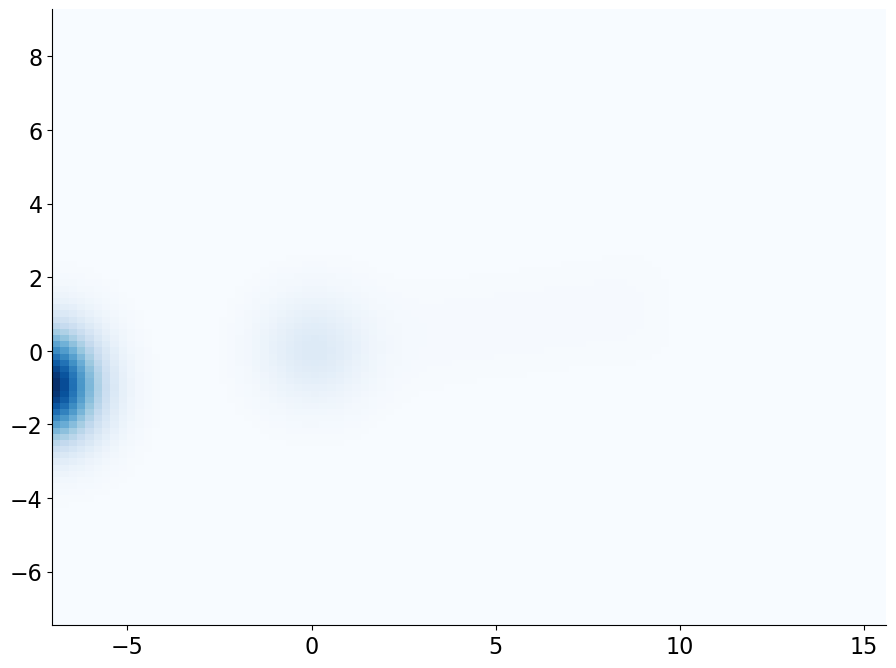

In [193]:
plt.imshow(Qs_f, origin = "lower", extent = (X.min(), X.max(), Y.min(), Y.max()), cmap = "Blues")

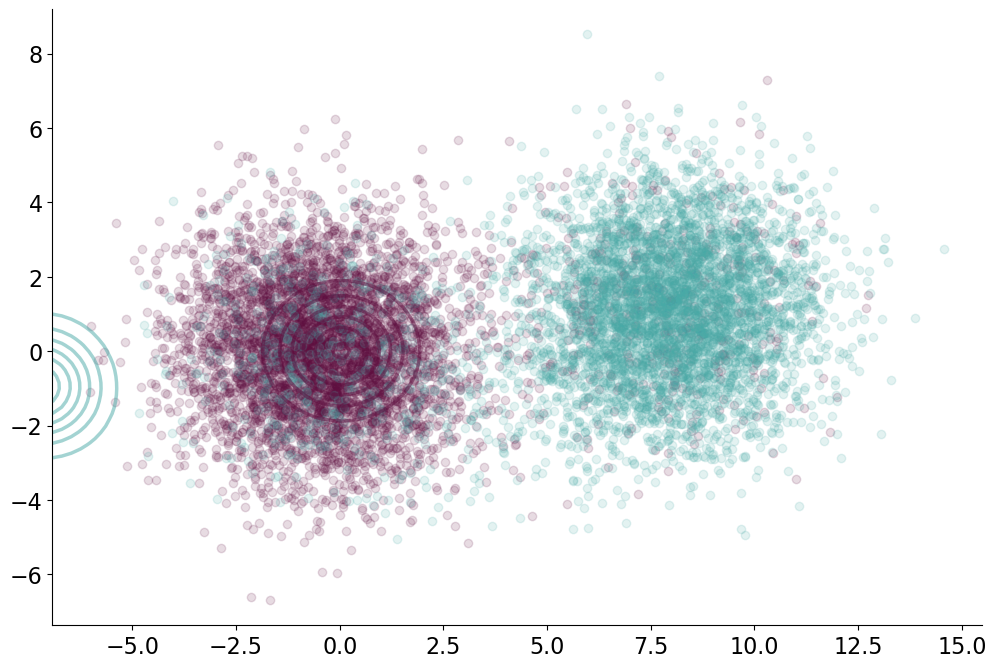

In [194]:
fig, ax = plt.subplots()

binsize = (xs[1] - xs[0]) * (ys[1] - ys[0])

img_i = ax.contour(binsize * Qs_i, extent = (xs[0], xs[-1], ys[0], ys[-1]), origin = "lower", colors = "C0", alpha = 0.5)
img_f = ax.contour(binsize * Qs_f, extent = (xs[0], xs[-1], ys[0], ys[-1]), origin = "lower", colors = "C1", alpha = 0.5)


ax.scatter(data_0.real, data_0.imag, cmap = "Blues", alpha = 0.15)
ax.scatter(data_1.real, data_1.imag, cmap = "Reds", alpha = 0.15)

In [195]:
qutip.expect(num(resonator_states), final_rho.ptrace(1))

24.891410933164135

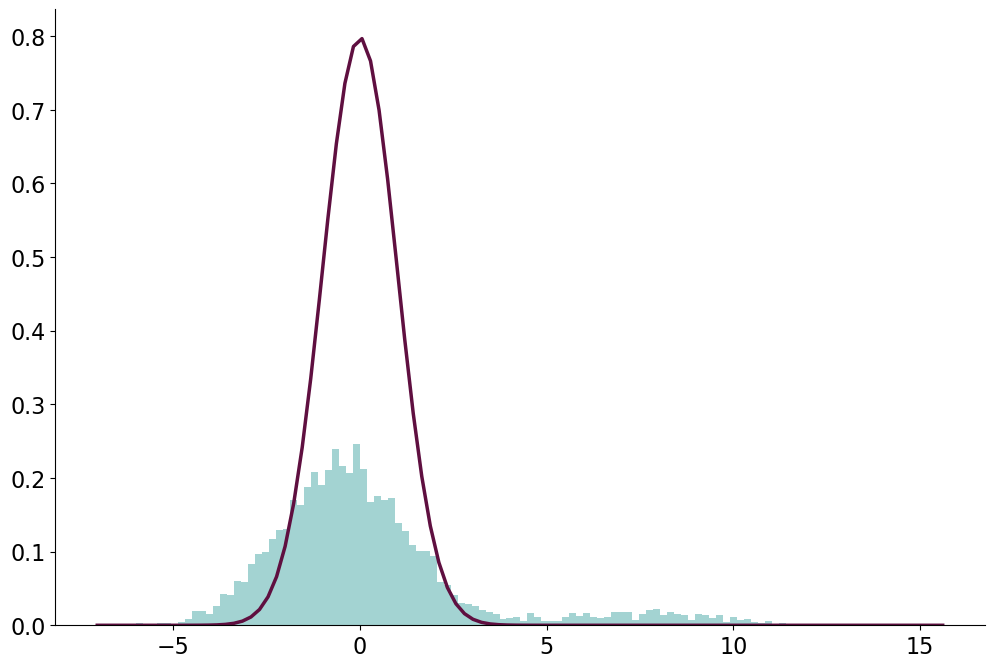

In [196]:
plt.plot(xs, (ys[1] - ys[0]) * Qs_i.sum(axis = 0))
plt.hist(data_0.real, bins = 100, density = True, alpha = 0.5);

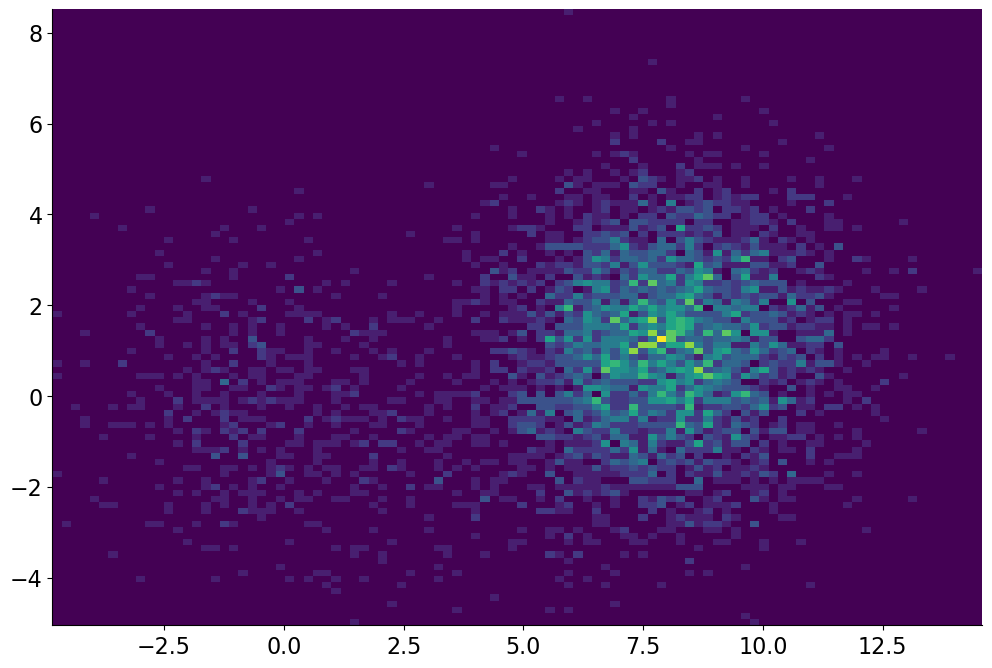

In [197]:
plt.hist2d(data_1.real, data_1.imag, bins = 100);